Image: Img_389.png, Width: 256, Height: 256


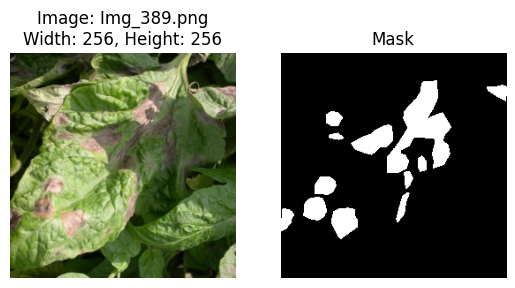

In [ ]:
#Review of an image and mask in the dataset
#Import libraries
import os
import cv2
import matplotlib.pyplot as plt

def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is not None:
        height, width = image.shape[:2]
        return width, height
    else:
        return None

# Replace 'image_folder_path' and 'mask_folder_path' with the actual paths to your image and mask folders on Kaggle
image_folder_path = '/content/sample_data/train_images'
mask_folder_path = '/content/sample_data/train_masks'

# List all the files in the image folder
image_files = os.listdir(image_folder_path)

if len(image_files) > 0:
    # Choose one image from the folder (you can change the index if needed)
    image_file = image_files[2]

    # Get the complete path to the image and mask
    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file  # Assuming mask file names are the same as image file names
    mask_path = os.path.join(mask_folder_path, mask_file)

    # Get the image size
    image_size = get_image_size(image_path)

    if image_size is not None:
        print(f"Image: {image_file}, Width: {image_size[0]}, Height: {image_size[1]}")

        # Load and plot the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        #image=image[:,:256]
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {image_file}\nWidth: {image_size[0]}, Height: {image_size[1]}")
        plt.axis('off')

        # Load and plot the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = mask[:,256:]
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to read the image: {image_file}")
else:
    print("No images found in the specified folder.")

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

SEGMENTATION MODEL - UNET

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
# Test the U Net model
def test():
    x = torch.randn((3,1, 256, 256))
    model = UNET(in_channels = 1, out_channels = 1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])


AttributeError: 'UNET' object has no attribute 'summary'

# **IMPORTING LIBRARIES**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# **DATASET CREATION**

In [ ]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
        #image = image[:,:256]
        #mask = mask[:,256:]
        if self.transform:
            # Apply any desired transformations (e.g., resizing, normalization, data augmentation)
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Function to create train and test data loaders
def create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=4):
    # Dataset transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images and masks to 256x256
        transforms.ToTensor(),
    ])

    # Create datasets
    train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform)
    val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transform)  # Validation dataset
    test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No need to shuffle the validation set
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# **TRAINING**

In [ ]:
# Function to train the UNet model and return the loss values
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    model.train()
    train_loss_values = []
    val_loss_values = []

    best_model_state = None
    best_loss = float('inf')

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for images, masks in train_loader:
            optimizer.zero_grad()

            # Move images and masks to device (GPU if available)
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate and store the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_values.append(epoch_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}")

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)

                val_running_loss += val_loss.item()

        # Calculate and store the average validation loss for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        val_loss_values.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}")

        if early_stopping is not None:
            early_stopping(epoch_val_loss)
            if early_stopping.stop_training:
                print("Early stopping the training process.")
                break

        # Update best model state if necessary
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_state = model.state_dict()

        model.train()

    return train_loss_values, val_loss_values, best_model_state

In [ ]:
# Function to save the best model's state to a file
def save_best_model(model_state, filename):
    torch.save(model_state, filename)

In [ ]:
import torch
import torch.nn.functional as F

# Function to calculate Intersection over Union (IoU)
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

In [ ]:
# Function to visualize images
def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert tensors to numpy arrays and remove batch dimension
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    # Visualize original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Visualize mask
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Visualize prediction
    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

I have ran only 10 epochs as the runtime was getting disconnected

Epoch 1/10, Train Loss: 0.2929977001622319
Epoch 1/10, Validation Loss: 0.17263592714848724
Epoch 2/10, Train Loss: 0.24132211773615816
Epoch 2/10, Validation Loss: 0.16365442619375561
Epoch 3/10, Train Loss: 0.24042396405306848
Epoch 3/10, Validation Loss: 0.20197856879752615
Epoch 4/10, Train Loss: 0.2381755292172665
Epoch 4/10, Validation Loss: 0.16343242383521536
Epoch 5/10, Train Loss: 0.236152907833457
Epoch 5/10, Validation Loss: 0.16182722880140596
Epoch 6/10, Train Loss: 0.23590076257191275
Epoch 6/10, Validation Loss: 0.17190375664959784
Epoch 7/10, Train Loss: 0.2308843278164125
Epoch 7/10, Validation Loss: 0.14924099652663522
Epoch 8/10, Train Loss: 0.23532324660893367
Epoch 8/10, Validation Loss: 0.15266332759157472
Epoch 9/10, Train Loss: 0.22670773607071326
Epoch 9/10, Validation Loss: 0.15468926363341187
Epoch 10/10, Train Loss: 0.22474556944697446
Epoch 10/10, Validation Loss: 0.15780629282412323


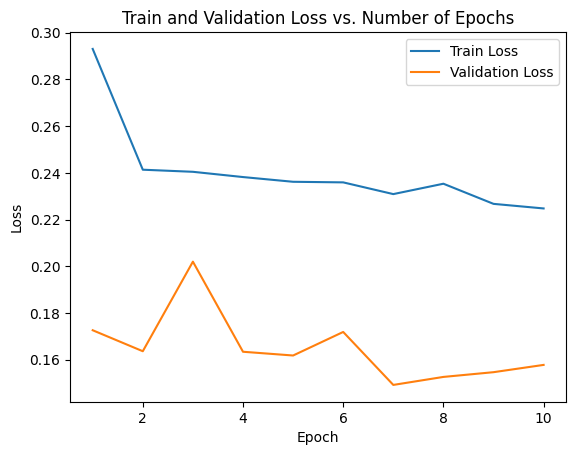

In [ ]:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
# Example usage:
if __name__ == "__main__":
    image_folder = '/content/sample_data/train_images'
    mask_folder = '/content/sample_data/train_masks'

    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, mask) for mask in os.listdir(mask_folder)]

    num_samples = len(image_paths)
    train_size = int(0.8 * num_samples)  # 80% for training and validation, 20% for testing
    val_size = (num_samples - train_size) // 2
    indices = np.random.permutation(num_samples)
    train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

    train_image_paths = [image_paths[i] for i in train_indices]
    train_mask_paths = [mask_paths[i] for i in train_indices]
    val_image_paths = [image_paths[i] for i in val_indices]
    val_mask_paths = [mask_paths[i] for i in val_indices]
    test_image_paths = [image_paths[i] for i in test_indices]
    test_mask_paths = [mask_paths[i] for i in test_indices]

    # Initialize the UNet model
    in_channels = 3
    out_channels = 1
    model = UNET(in_channels, out_channels)

    # Move the model to the device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=4)

    # Initialize the EarlyStopping callback with patience=5 and mode='min'
    early_stopping = EarlyStopping(patience=5, mode='min')

    # Train the model
    num_epochs = 10
    train_loss_values, val_loss_values, best_model_state = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # Plot the train and valdiation loss vs. the number of epochs
    plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Train Loss")
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss vs. Number of Epochs")
    plt.legend()
    plt.show()

    # Save the best model's state to a file
    if best_model_state is not None:
        save_best_model(best_model_state, "best_model.pth")

In [ ]:
import torch

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten predictions and ground truth masks
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    # Calculate intersection and union
    intersection = torch.sum(y_true_flat * y_pred_flat)
    union = torch.sum(y_true_flat) + torch.sum(y_pred_flat)

    # Calculate Dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice


TRAIN SET TESTING

Average IoU for the train set: 0.2918
Dice coefficient: tensor(0.3163, device='cuda:0')


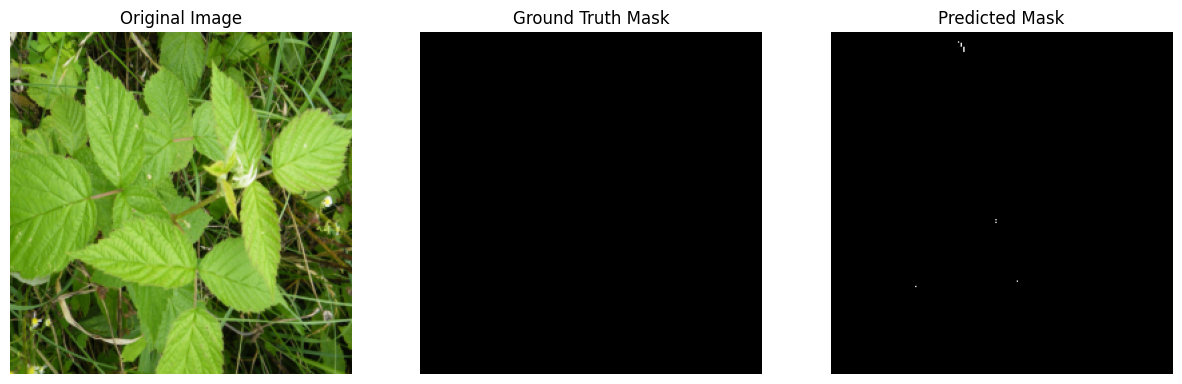

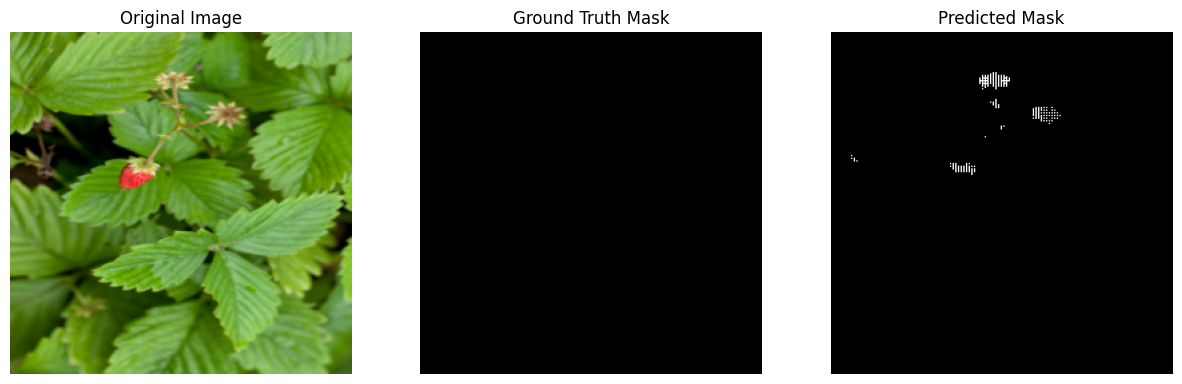

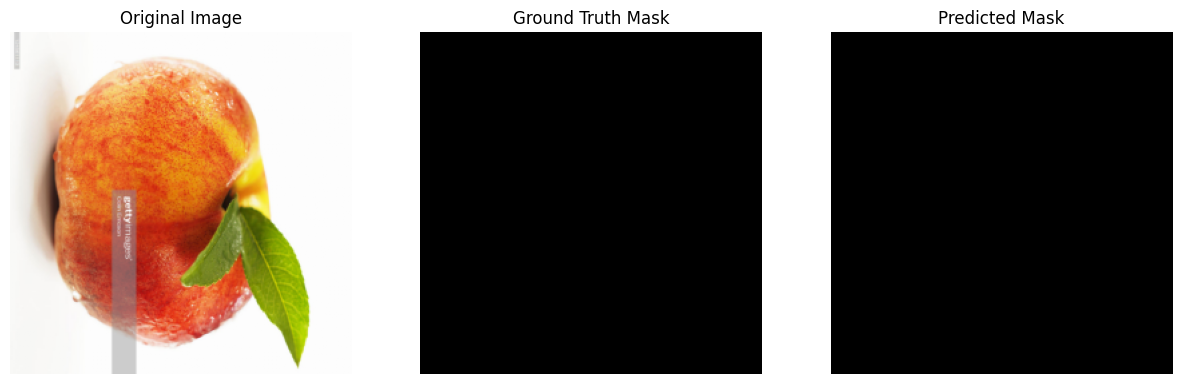

In [ ]:
# Test the model and calculate IoU for the train set
iou_scores = []
dice_c = []
with torch.no_grad():
    model.eval()
    for images, masks in train_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        binary_masks = (predictions > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(binary_masks[i], masks[i])
            iou_scores.append(iou)
            dc = dice_coefficient(masks[i], binary_masks[i])
            dice_c.append(dc)



# Calculate the average IoU for the entire test set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the train set: {average_iou:.4f}")

dice = sum(dice_c) / len(dice_c)
# Print the result
print("Dice coefficient:", dice)

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(train_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        # Get model predictions
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        # Convert predictions to binary masks based on the threshold
        binary_mask = (prediction > 0.5).float()

        #print(binary_masks)

        #print(mask)

        # Visualize the images
        #visualize_images(image[0], mask[0], torch.sigmoid(prediction)[0])
        visualize_images(image[0], mask[0], binary_mask[0])

VALIDATION SET TESTING

Average IoU for the train set: 0.3963
Dice coefficient: tensor(0.4211, device='cuda:0')


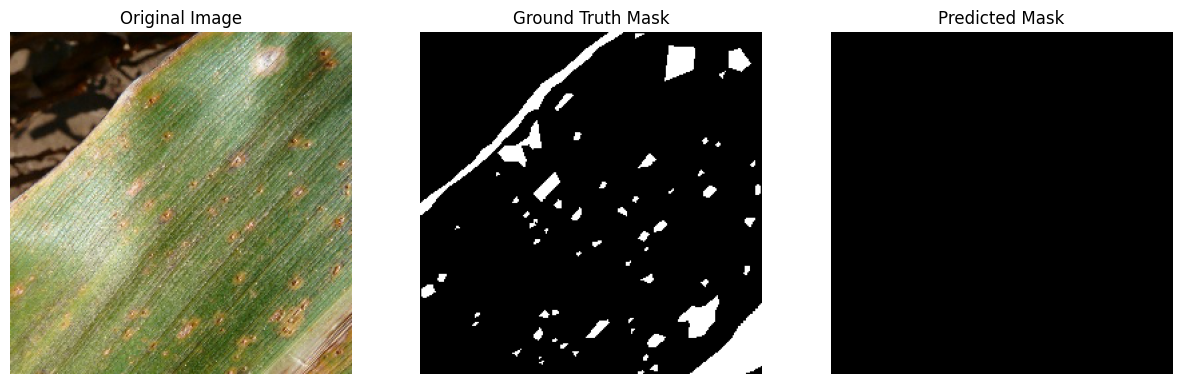

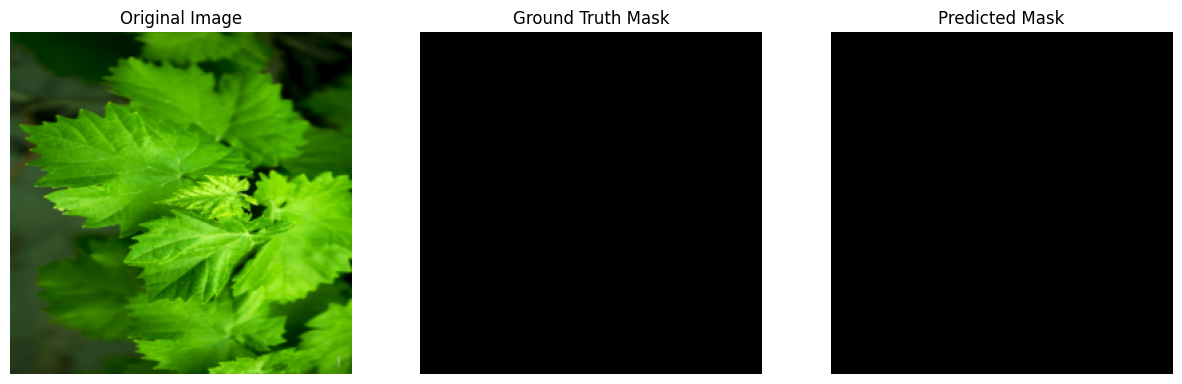

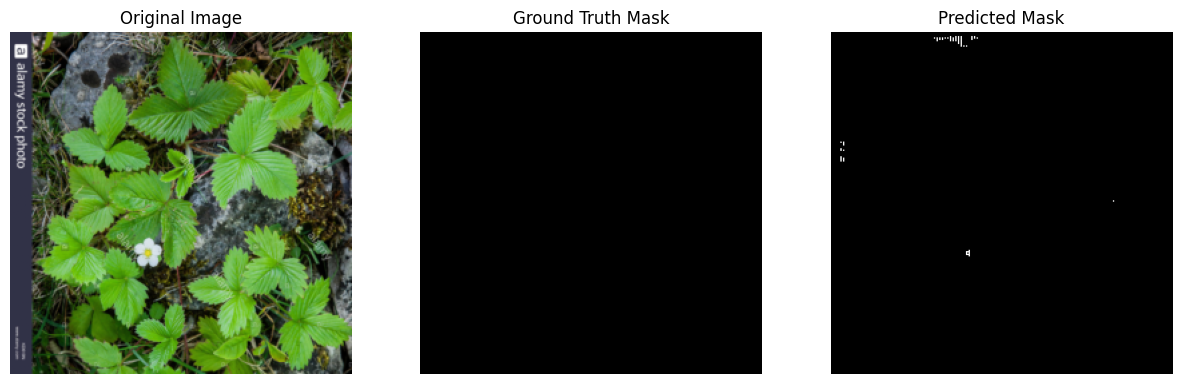

In [ ]:
# Test the model and calculate IoU for the train set
iou_scores = []
dice_c = []
with torch.no_grad():
    model.eval()
    for images, masks in val_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        binary_masks = (predictions > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(binary_masks[i], masks[i])
            iou_scores.append(iou)
            dc = dice_coefficient(masks[i], binary_masks[i])
            dice_c.append(dc)



# Calculate the average IoU for the entire test set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the train set: {average_iou:.4f}")

dice = sum(dice_c) / len(dice_c)
# Print the result
print("Dice coefficient:", dice)

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        # Get model predictions
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        # Convert predictions to binary masks based on the threshold
        binary_mask = (prediction > 0.5).float()

        #print(binary_masks)

        #print(mask)

        # Visualize the images
        #visualize_images(image[0], mask[0], torch.sigmoid(prediction)[0])
        visualize_images(image[0], mask[0], binary_mask[0])

TESTING SET

Average IoU for the train set: 0.3081
Dice coefficient: tensor(0.3334, device='cuda:0')
torch.Size([4, 3, 256, 256])


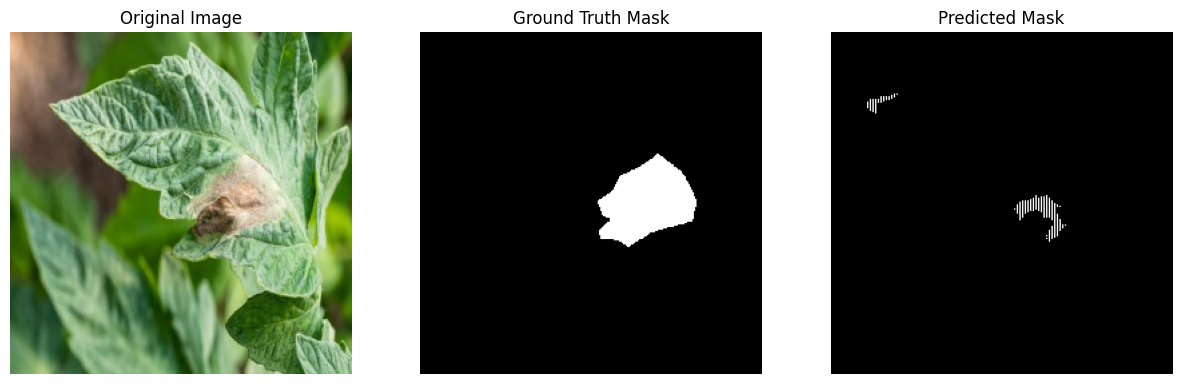

torch.Size([4, 3, 256, 256])


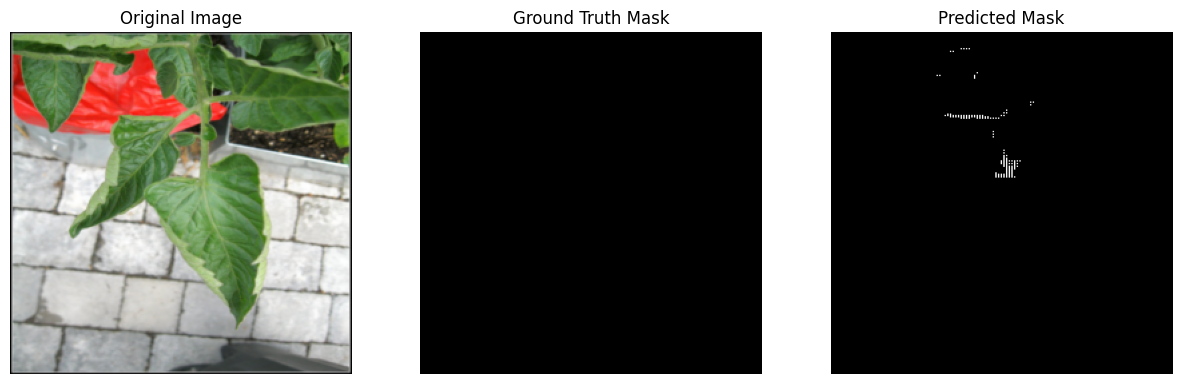

torch.Size([4, 3, 256, 256])


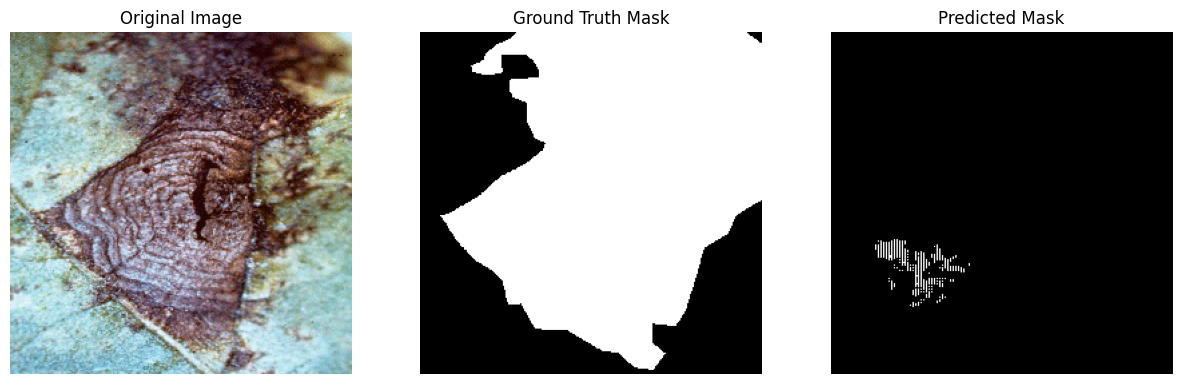

In [ ]:
# Test the model and calculate IoU for the train set
iou_scores = []
dice_c = []
with torch.no_grad():
    model.eval()
    for images, masks in test_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        binary_masks = (predictions > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(binary_masks[i], masks[i])
            iou_scores.append(iou)
            dc = dice_coefficient(masks[i], binary_masks[i])
            dice_c.append(dc)



# Calculate the average IoU for the entire test set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the train set: {average_iou:.4f}")

dice = sum(dice_c) / len(dice_c)
# Print the result
print("Dice coefficient:", dice)

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(test_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        print(image.shape)
        # Get model predictions
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        # Convert predictions to binary masks based on the threshold
        binary_mask = (prediction > 0.5).float()

        #print(binary_masks)

        #print(mask)

        # Visualize the images
        #visualize_images(image[0], mask[0], torch.sigmoid(prediction)[0])
        visualize_images(image[0], mask[0], binary_mask[0])

# **CREATING FINAL TESTING DATASET**

In [ ]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        #self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        #mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
        #mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
        #image = image[:,:256]
        #mask = mask[:,256:]
        if self.transform:
            # Apply any desired transformations (e.g., resizing, normalization, data augmentation)
            image = self.transform(image)
            #mask = self.transform(mask)

        return image, image_path

In [ ]:
# Function to create train and test data loaders
def create_data_loaders(train_image_paths,batch_size=4):
    # Dataset transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images and masks to 256x256
        transforms.ToTensor(),
    ])

    # Create datasets
    final_test_dataset = CustomDataset(train_image_paths, transform=transform)
    #val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transform)  # Validation dataset
    #test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)

    # Create data loaders
    final_test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=True)
    #val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No need to shuffle the validation set
    #test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return final_test_loader

In [ ]:

if __name__ == "__main__":
    image_folder = '/content/sample_data/test_images'

    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]

    num_samples = len(image_paths)
    indices = np.random.permutation(num_samples)
    train_indices = indices[:train_size]

    train_image_paths = [image_paths[i] for i in train_indices]# Create data loaders
    final_test_loader= create_data_loaders(train_image_paths, batch_size=4)

torch.Size([4, 3, 256, 256])
/content/sample_data/test_images/Img_1032.png


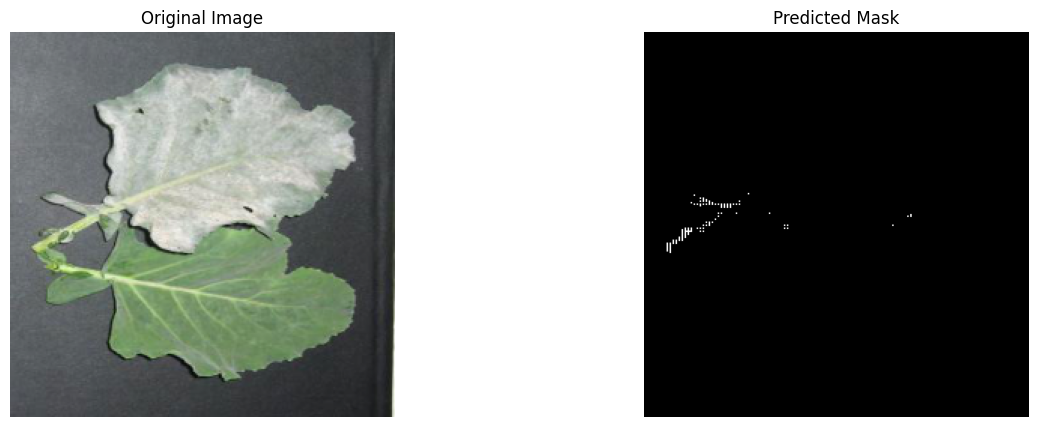

torch.Size([4, 3, 256, 256])
/content/sample_data/test_images/Img_1123.png


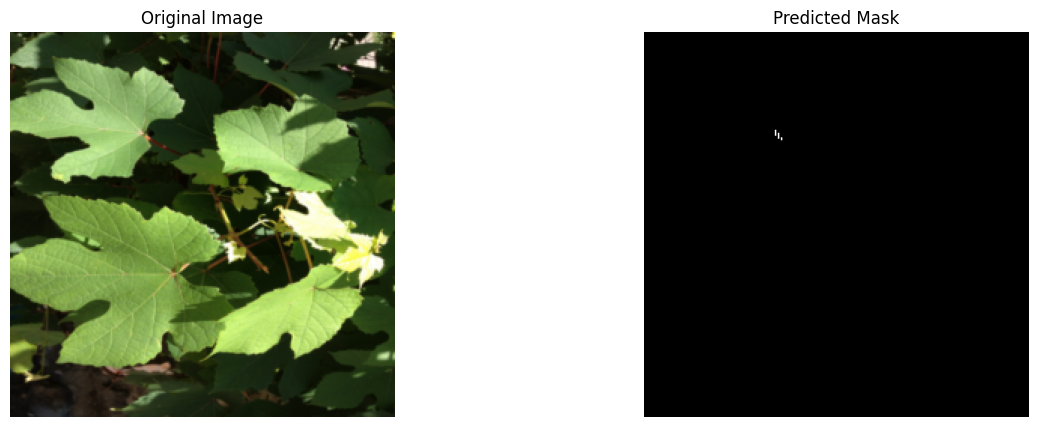

torch.Size([4, 3, 256, 256])
/content/sample_data/test_images/Img_950.png


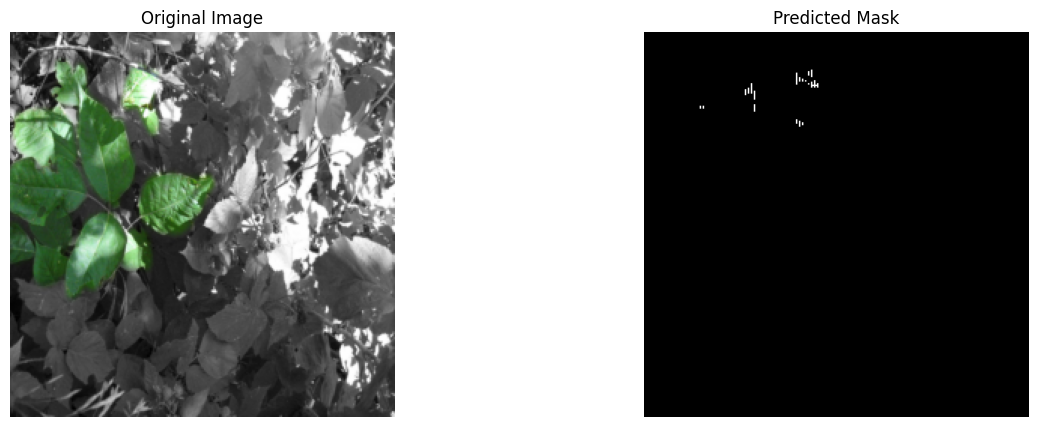

In [ ]:

with torch.no_grad():
    model.eval()
    for images, image_paths in final_test_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        binary_masks = (predictions > 0.5).float()


# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, path) in enumerate(final_test_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        print(image.shape)
        print(path[1])
        # Get model predictions
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        # Convert predictions to binary masks based on the threshold
        binary_mask = (prediction > 0.5).float()

        # Visualize the images
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Convert tensors to numpy arrays and remove batch dimension
        prediction = torch.sigmoid(prediction)[1]
        image = image[1].permute(1, 2, 0).cpu().numpy()
        prediction = binary_mask[1].squeeze().cpu().numpy()



        # Visualize original image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Visualize prediction
        axes[1].imshow(prediction, cmap="gray")
        axes[1].set_title("Predicted Mask")
        axes[1].axis("off")

        plt.show()


# **CONVERSION TO RLE**

In [ ]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**SAVING RESULTS IN CSV**

In [ ]:
from google.colab import drive
import csv


# Define the path to save the CSV file
output_csv = '/content/sample_data/predictions.csv'

# Create a list to store the results
results = []

with torch.no_grad():
    model.eval()
    for images, image_paths in final_test_loader:
        # Move images to device (GPU if available)
        images = images.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        binary_masks = (predictions > 0.5).float()

        # Convert binary masks to NumPy arrays
        binary_masks = binary_masks.cpu().numpy()

        # Iterate over each image and its path
        for i in range(len(image_paths)):
            # Extract image path
            image_path = image_paths[i]

            # Extract binary mask
            binary_mask = binary_masks[i]

            rle = mask2rle(binary_mask)

            # Check if RLE is empty
            if not rle:
                rle = 'Healthy'

            # Append image path and binary mask to the results list
            results.append((image_path, binary_mask, rle))

# Write the results to a CSV file
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image_Path', 'Binary_Mask', 'rle'])
    for result in results:
        writer.writerow([result[0], result[1], result[2]])


print("CSV file created and saved at:", output_csv)


CSV file created and saved at: /content/sample_data/predictions.csv


In [ ]:
# Assuming binary_masks is a NumPy array containing binary masks
one_binary_mask = binary_masks[0]
print("Shape of one binary mask:", one_binary_mask.shape)


Shape of one binary mask: (1, 256, 256)


In [ ]:
mask2rle(binary_masks[0])

'14210 1 14722 1 15234 2 15746 2 16259 2 16771 3 17283 3 17795 4 18308 4 18820 5 19078 1 19332 6 19590 1 19592 1 19844 8 20102 1 20104 1 20106 1 20355 13 20612 5 20618 1 20620 1 20622 1 20867 14 21126 1 21132 1 21134 1 21379 15 21893 5 22407 2 22919 1 29061 1 29573 1 30084 2 30596 2 31108 2 31619 3 32131 3 32643 3'

The next steps are done to sort the rows according to image names

In [ ]:
import re
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(output_csv)

# Extract image names from image paths
df['Image_Name'] = df['Image_Path'].apply(lambda x: re.search(r'[^/]+(?=\.\w+$)', x).group(0))

# Sort the DataFrame by the extracted image names
df.sort_values(by='Image_Name', inplace=True)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Save the sorted DataFrame to a new CSV file
sorted_output_csv = '/content/sample_data/sorted_predictions.csv'
df.to_csv(sorted_output_csv, index=False)

print("CSV file with sorted predictions created and saved at:", sorted_output_csv)


CSV file with sorted predictions created and saved at: /content/sample_data/sorted_predictions.csv


In [ ]:
import re
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(output_csv)

# Extract and sort the numbers from the image paths
df['Image_Number'] = df['Image_Path'].apply(lambda x: int(re.search(r'\d+', x).group()))
df = df.sort_values(by='Image_Number')

# Update the image paths and corresponding columns based on the sorted numbers
df['Image_Path'] = '/content/sample_data/test_images/Img_' + df['Image_Number'].astype(str) + '.png'


# Save the sorted DataFrame to a new CSV file
sorted_output_csv = '/content/sample_data/sorted_predictions_2.csv'
# Save the updated DataFrame to the CSV file
df.to_csv(output_csv, index=False)

print("CSV file updated and saved at:", output_csv)


CSV file updated and saved at: /content/sample_data/predictions.csv
